In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import itertools
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
params = {'xtick.labelsize':'x-large', 'ytick.labelsize':'x-large',
         'figure.figsize': (12,5), "axes.labelsize":'x-large'}
plt.rcParams.update(params)

In [27]:
data = pd.read_pickle('res_race_randomized.p')
print(len(data))

2972


In [28]:
data['sample_size'] = data.g1t + data.g2t
data = data.rename(columns={'imbal':'imbalance'})
data.head()

,effect,g1_mean,g2_mean,g1_sd_sample,g2_sd_sample,imbalance,ngrps,g1t,g2t,g1counts,g2counts,grouplabels,sample_size
NCT00000392,0.237493,77.0,66.0,0.263249,0.406202,0.101003,3,104,108,"[5.0, 16.0, 83.0]","[5.0, 9.0, 94.0]","[Black, Hispanic, White]",212
NCT00001262,1.308937,22.0,35.0,2.943000,12.034000,0.323374,7,35,22,"[0.0, 0.0, 9.0, 1.0, 0.0, 3.0, 22.0]","[0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 19.0]","[American Indian or Alaska Native, Asian, Blac...",57
NCT00001304,5.943921,14.0,13.0,0.270000,0.510000,0.101015,7,13,14,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 13.0]","[American Indian or Alaska Native, Asian, Blac...",27
NCT00002651,0.110639,465.0,446.0,17.432223,15.556043,0.019024,7,765,770,"[2.0, 5.0, 93.0, 2.0, 2.0, 154.0, 507.0]","[4.0, 8.0, 94.0, 1.0, 0.0, 144.0, 519.0]","[American Indian or Alaska Native, Asian, Blac...",1535
NCT00004732,0.014136,1240.0,1262.0,28.170907,28.419711,0.009706,3,1262,1240,"[81.0, 9.0, 1172.0]","[71.0, 9.0, 1160.0]","[Non-White, Not Specified, White]",2502


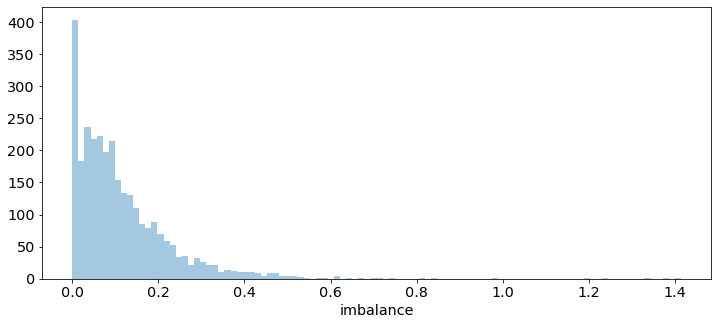

In [29]:
sns.distplot(data['imbalance'], kde=False, bins=100)

In [30]:
data.imbalance.describe(np.arange(0, 1, 0.05))

count    2972.000000
mean        0.117240
std         0.124461
min         0.000000
0%          0.000000
5%          0.000000
10%         0.000000
15%         0.018662
20%         0.028722
25%         0.037406
30%         0.047140
35%         0.056554
40%         0.065626
45%         0.075286
50%         0.086847
55%         0.096594
60%         0.108786
65%         0.122637
70%         0.139740
75%         0.159004
80%         0.186392
85%         0.212132
90%         0.256385
95%         0.332756
max         1.414214
Name: imbalance, dtype: float64

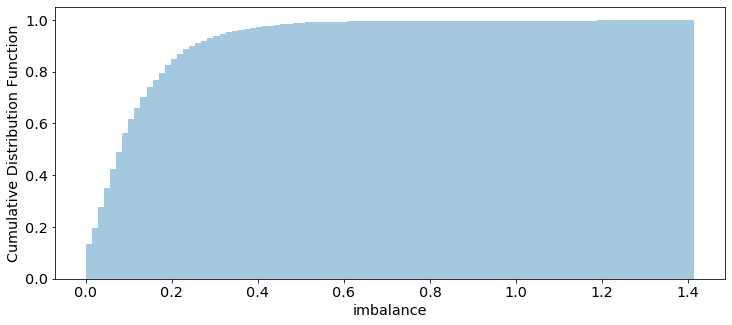

In [31]:
sns.distplot(
    data['imbalance'], kde=False, hist_kws={'cumulative': True}, norm_hist=True,
    bins=100
)
plt.ylabel('Cumulative Distribution Function')
plt.show()

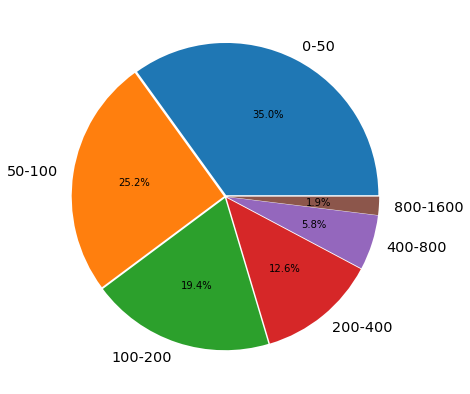

In [32]:
# trial size distribution
labels = []
shares = []

sample_sizes = [0, 50, 100, 200, 400, 800, 1600]
for i in range(len(sample_sizes)-1):
    lower, upper = sample_sizes[i:i+2]
    shares.append(
        data.sample_size.between(lower, upper).mean().round(2))
    labels.append('{}-{}'.format(lower, upper))    
    
plt.figure(figsize=(7, 7))
plt.pie(shares, explode=[.01] * len(shares), labels=labels, autopct='%.1f%%')
plt.show()

In [33]:
data.sample_size.describe()

count      2972.000000
mean        213.926985
std        2104.474497
min           4.000000
25%          39.000000
50%          72.000000
75%         169.000000
max      103048.000000
Name: sample_size, dtype: float64

In [34]:
# ensure treatment and control groups are of similar sizes?
data = data.loc[np.log(data.g1t/data.g2t).abs() <= np.log(3)]
print(data.shape)

(2925, 13)


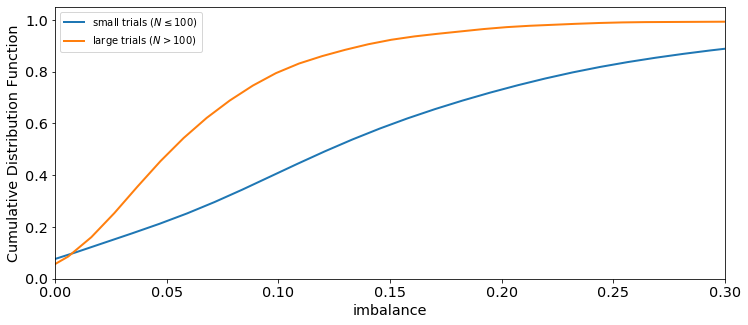

In [35]:
sns.distplot(
    data['imbalance'].loc[data.sample_size.between(0,100)], hist=False,
    kde_kws={'cumulative': True, "lw": 2, "label": "small trials $(N \leq 100)$"}, 
    norm_hist=True, 
    bins=100
)
sns.distplot(
    data['imbalance'].loc[data.sample_size > 100], hist=False,
    kde_kws={'cumulative': True, "lw": 2, "label": 'large trials $(N > 100)$'}, 
    norm_hist=True,
    bins=100
)
plt.xlim(0, .3)
plt.ylabel('Cumulative Distribution Function')
plt.show()

### Relative Imbalance was skipped, potentially it can be implementable if we look through the multi buckets

In [36]:
# additional variables

def average_sd(x):
    g1t, g2t, g1_sd_sample, g2_sd_sample = x
    return np.sqrt(g1t * g1_sd_sample **2 + g2t * g2_sd_sample ** 2) / np.sqrt(g1t + g2t)
    
data['average_sd'] = data[['g1t', 'g2t', 'g1_sd_sample', 'g2_sd_sample']].apply(
    average_sd, axis=1
)
data.head().T

,NCT00000392,NCT00001262,NCT00001304,NCT00002651,NCT00004732
effect,0.237493,1.30894,5.94392,0.110639,0.0141359
g1_mean,77,22,14,465,1240
g2_mean,66,35,13,446,1262
g1_sd_sample,0.263249,2.943,0.27,17.4322,28.1709
g2_sd_sample,0.406202,12.034,0.51,15.556,28.4197
imbalance,0.101003,0.323374,0.101015,0.0190241,0.00970629
ngrps,3,7,7,7,3
g1t,104,35,13,765,1262
g2t,108,22,14,770,1240
g1counts,"[5.0, 16.0, 83.0]","[0.0, 0.0, 9.0, 1.0, 0.0, 3.0, 22.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0]","[2.0, 5.0, 93.0, 2.0, 2.0, 154.0, 507.0]","[81.0, 9.0, 1172.0]"


In [37]:
data['signed_effect'] = (data['g1_mean'] - data['g2_mean']) / data['average_sd']
data['effect_size'] = data.signed_effect.abs()
data['bias'] = (1/data.g1t) + (1/data.g2t)
data['inverse_sample_size'] = 1/data.sample_size
data = data.loc[data.signed_effect.abs() < 3]

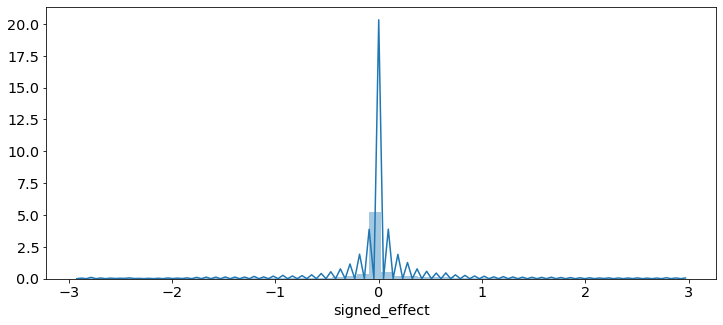

In [38]:
sns.distplot(data.signed_effect)

In [39]:
selected_data = data.copy()
selected_data = selected_data.loc[selected_data.imbalance.between(.02, .25)]

In [40]:
selected_data['residuals'] = np.square(selected_data.signed_effect
                                       - selected_data.signed_effect.mean()) - selected_data.bias
selected_data['square_imbalance'] = np.square(selected_data.imbalance)

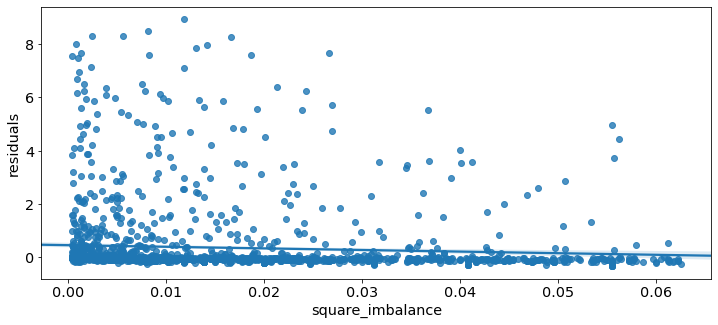

In [41]:
sns.regplot('square_imbalance', 'residuals', selected_data)

In [42]:
import matplotlib.ticker as mtick

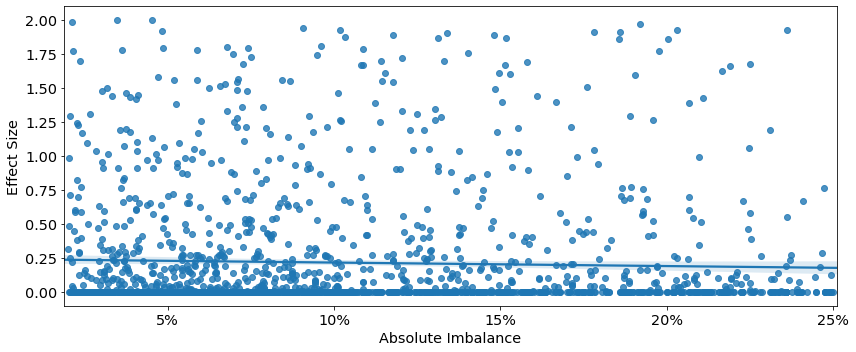

In [43]:
ax = sns.regplot('imbalance', 'effect_size', selected_data.loc[selected_data.effect_size <2])
plt.ylabel('Effect Size')
plt.xlabel('Absolute Imbalance')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.xlim(0.019,.251)
plt.tight_layout()
# plt.savefig('figs/regplot_imbalance_effect_size.pdf')
plt.show()

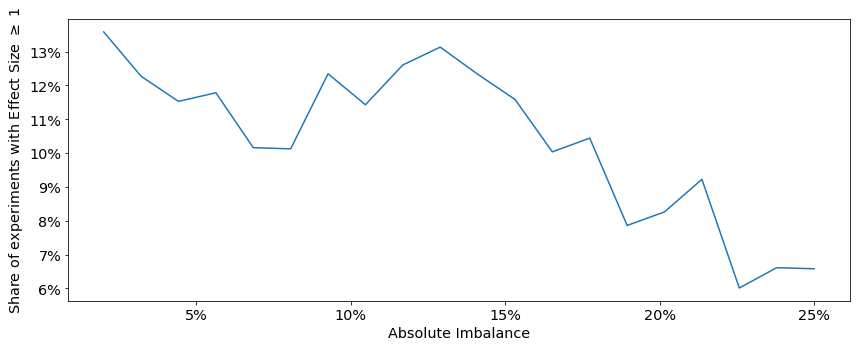

In [44]:
step = .025
share_large_effects = []

for imbalance in np.linspace(.02, .25, 20):
    is_large = (selected_data.loc[selected_data.imbalance.between(imbalance - step, imbalance + step)
                             ].effect_size >= 1)
    share_large_effects.append(is_large.mean())
    std_error = [is_large.std()]
share_large_effects

fig, ax = plt.subplots()
plt.plot(np.linspace(.02, .25, 20), share_large_effects)
plt.xlabel('Absolute Imbalance')
plt.ylabel('Share of experiments with Effect Size $\geq$ 1')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

plt.tight_layout()
# plt.savefig('figs/regplot_imbalance_large_effect_size.pdf')
plt.show()

In [45]:
mod = smf.ols('effect_size ~ imbalance', selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            effect_size   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     6.338
Date:                Sun, 27 Dec 2020   Prob (F-statistic):             0.0119
Time:                        18:12:30   Log-Likelihood:                -1681.9
No. Observations:                1887   AIC:                             3368.
Df Residuals:                    1885   BIC:                             3379.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3583      0.028     13.013      0.0

In [46]:
mod = smf.ols('effect_size ~ imbalance + inverse_sample_size' , selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            effect_size   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     12.77
Date:                Sun, 27 Dec 2020   Prob (F-statistic):           3.11e-06
Time:                        18:12:31   Log-Likelihood:                -1672.4
No. Observations:                1887   AIC:                             3351.
Df Residuals:                    1884   BIC:                             3367.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.3817    

In [47]:
mod = smf.ols('residuals ~ square_imbalance', selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     9.566
Date:                Sun, 27 Dec 2020   Prob (F-statistic):            0.00201
Time:                        18:12:31   Log-Likelihood:                -3136.2
No. Observations:                1887   AIC:                             6276.
Df Residuals:                    1885   BIC:                             6288.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4588      0.041  

In [48]:
mod = smf.ols('residuals ~ square_imbalance + inverse_sample_size', selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     15.62
Date:                Sun, 27 Dec 2020   Prob (F-statistic):           1.88e-07
Time:                        18:12:31   Log-Likelihood:                -3125.5
No. Observations:                1887   AIC:                             6257.
Df Residuals:                    1884   BIC:                             6274.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5776    

In [49]:
mod = smf.quantreg('residuals ~ square_imbalance', selected_data)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:              residuals   Pseudo R-squared:             0.008461
Model:                       QuantReg   Bandwidth:                     0.03169
Method:                 Least Squares   Sparsity:                       0.1375
Date:                Sun, 27 Dec 2020   No. Observations:                 1887
Time:                        18:12:31   Df Residuals:                     1885
                                        Df Model:                            1
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0130      0.002     -5.913      0.000      -0.017      -0.009
square_imbalance    -1.6525      0.105    -15.781      0.000      -1.858      -1.447


In [50]:
mod = smf.quantreg('residuals ~ square_imbalance + inverse_sample_size', selected_data)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:              residuals   Pseudo R-squared:              0.05687
Model:                       QuantReg   Bandwidth:                     0.02233
Method:                 Least Squares   Sparsity:                      0.04489
Date:                Sun, 27 Dec 2020   No. Observations:                 1887
Time:                        18:12:32   Df Residuals:                     1884
                                        Df Model:                            2
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0007      0.001      0.839      0.401      -0.001       0.002
square_imbalance     1.514e-06      0.039   3.89e-05      1.000      -0.076       0.076
inverse_sample_size    -4.0000      0.044    -90.447      0.000      -4.087      -3.913
